# Interfacing *torch* to *heyoka.py*

```{note}
For an introduction on feed forward neural networks in *heyoka.py*, check out the example: [Feed-Forward Neural Networks](<./ffnn.ipynb>).
```


```{warning}
This tutorial assumes [torch](https://pytorch.org/) is installed
```

*heyoka.py* is not a library meant for machine learning, nor it aspires to be one. However, given its support for feed-forward neural networks and their potential use in numerical integration, it is useful to connect the *heyoka.py* `ffnn()` factory to a torch model. This tutorial tackles this! 

In [1]:
import heyoka as hk

import numpy as np

# We will need torch for this notebook. The CPU version is enough though.
import torch
from torch import nn

We start defining a `ffnn` model in *torch*. We use as a test-case, a feed-forward neural network with two hidden layers having 32 neurons each and use `tanh` as nonlinearities and a `sigmoid` for the output layer. We define the model as to map it easily to the *heyoka* `ffnn` factory, but other styles are also possible.

This will typically look something like:

In [2]:
#Let us use float64 (this is not necessary as heyoka has also the float32 type, but we go for high precision here!)
torch.set_default_dtype(torch.float64)

class torch_net(nn.Module):
    def __init__(
        self,
        n_inputs=4,
        nn_hidden=[32, 32],
        n_out=1,
        activations=[nn.Tanh(), nn.Tanh(), nn.Sigmoid()]
    ):
        super(torch_net, self).__init__()

        # We treat all layers equally.
        dims = [n_inputs] + nn_hidden + [n_out]

        # Linear function.
        self.fcs = nn.ModuleList([nn.Linear(dims[i], dims[i + 1]) for i in range(len(dims) - 1)])

        # Non-linearities.
        self.acts = nn.ModuleList(activations)

    def forward(self, x):
        for fc, act in zip(self.fcs, self.acts):
            x = act(fc(x))
        return x


Weights and biases are stored by *torch* in the model as arrays, while *heyoka* flattens everything into a one-dimensional sequence containing all weights first, then all biases.

The following function takes care of converting the *torch* representation to *heyoka*'s: 

In [3]:
def weights_and_biases_heyoka(model):
    weights = {}
    biases = {}

    for name, param in model.named_parameters():
        if 'weight' in name:
            weights[name] = param.data.clone()
        elif 'bias' in name:
            biases[name] = param.data.clone()
    biases_torch=[]
    weights_torch=[]
    for idx in range(len(weights)):
        weights_torch.append(weights[list(weights.keys())[idx]].numpy())
        biases_torch.append(biases[list(biases.keys())[idx]].numpy())
        
    w_flat=[]
    b_flat=[]
    for i in range(len(weights_torch)):
        w_flat+=list(weights_torch[i].flatten())
        b_flat+=list(biases_torch[i].flatten())
    w_flat=np.array(w_flat)
    b_flat=np.array(b_flat)
    print(w_flat.shape)
    return np.concatenate((w_flat, b_flat))

We are now ready to instantiate the model and extract its weights and biases ready for constructing an `heyoka.ffnn` object:

In [4]:
model = torch_net(n_inputs=4, 
                  nn_hidden=[32, 32],
                  n_out=1,
                  activations=[nn.Tanh(), nn.Tanh(), nn.Sigmoid()])

# Here one would likely perform some training ... at the end, we extract the model parameters:
flattened_weights = weights_and_biases_heyoka(model)

(1184,)


Let us instantiate the feed forward neural network in *heyoka.py* using those parameters:

In [5]:
inp_1, inp_2, inp_3, inp_4=hk.make_vars("inp_1","inp_2","inp_3","inp_4")
model_heyoka=hk.model.ffnn(inputs=[inp_1, inp_2, inp_3, inp_4], 
                           nn_hidden=[32,32], 
                           n_out=1,
                           activations=[hk.tanh,hk.tanh,hk.sigmoid], 
                           nn_wb=flattened_weights)

Good! Just to be sure, we now verify the output is the same at inference? Let's first compile the network so that we can run inference: 

In [6]:
model_heyoka_compiled=hk.cfunc(model_heyoka, [inp_1, inp_2, inp_3, inp_4])

... and create some random inputs

In [7]:
random_input=torch.rand((4,1000000))
random_input_torch=random_input.t()
random_input_numpy=random_input.numpy()
out_array=np.zeros((1,1000000))

Now, let's compare the output of `heyoka.ffnn` and `torch` to see if they are identical

In [8]:
t_hey = model_heyoka_compiled(random_input_numpy,outputs=out_array)
t_torch = model(random_input_torch).detach().numpy().reshape(1,-1)

In [9]:
print("Maximum difference in the inference is: ", (t_hey-t_torch).max())

Maximum difference in the inference is:  1.1102230246251565e-16


In this way we have managed to port the *torch* model in *heyoka.py*, reproducing the same results... 

# Using *torch* optimizers


An some cases the parameters of the neural network may need to be updated with *heyoka.py* in the loop, check out the example: [Neural ODEs](<./NeuralODEs_II.ipynb>). 

This part shows how to interface with optimizers (in this case Adam) provided by *torch*.

In the following we use a simplified version of [Neural ODEs](<./NeuralODEs_II.ipynb>), where a feedforward neural network learns the underlying dynamics of a liner system through observations.


In [10]:
import matplotlib.pylab as plt

Dynamics

$$
\left\{
\begin{array}{l}
\dot x = Ax + b
\end{array}
\right.
$$

In [11]:
# We now assemble the dynamics
A = np.array([
    [ 0. ,  0. ,  0. ,  1. ,  0. ,  0. ],
    [ 0. ,  0. ,  0. ,  0. ,  1. ,  0. ],
    [ 0. ,  0. ,  0. ,  0. ,  0. ,  1. ],
    [-2.5,  2. ,  0. ,  0. ,  0. ,  0. ],
    [ 2. , -5.4,  3.4,  0. ,  0. ,  0. ],
    [ 0. ,  3.4, -3.4,  0. ,  0. ,  0. ]
])

b = [0, 0, 0, -3.5, 0.26, 3.74]

n = len(b)
assert A.shape == (n, n)

x_vars = hk.make_vars(*[f"x_{i}" for i in range(1, n + 1)])

Ax_b =  A @ np.array(x_vars) + b
dynamics = list(zip(x_vars, Ax_b))

Setup

In [12]:
# This is the number of observations (i.e. the ground truth).
data_size = 1000
# This is the number of initial conditions to use in one batch (M)
batch_size_ic = 20
# This is the number of observations to predict from each sampled initial condition (T)
batch_size_time = 10
# This is the initial condition used to generate the observations (of the real dynamics)
ic = [2.0, 0.0, 0.0, 1.0, 0.0, 0.0]
# This is the time grid used to generate the observations
t_grid = np.linspace(0.0, 20, data_size)

The taylor integrator we use for the ground truth

In [13]:
ta = hk.taylor_adaptive(
    # The ODEs.
    dynamics,
    # The initial conditions.
    ic,
    # Operate in compact mode.
    compact_mode=False,
    # Define the tolerance
    tol=1e-18,
)

We generate the ground truth (observations)

In [14]:
ta.time = 0
ta.state[:] = ic
gt = ta.propagate_grid(t_grid)[5]

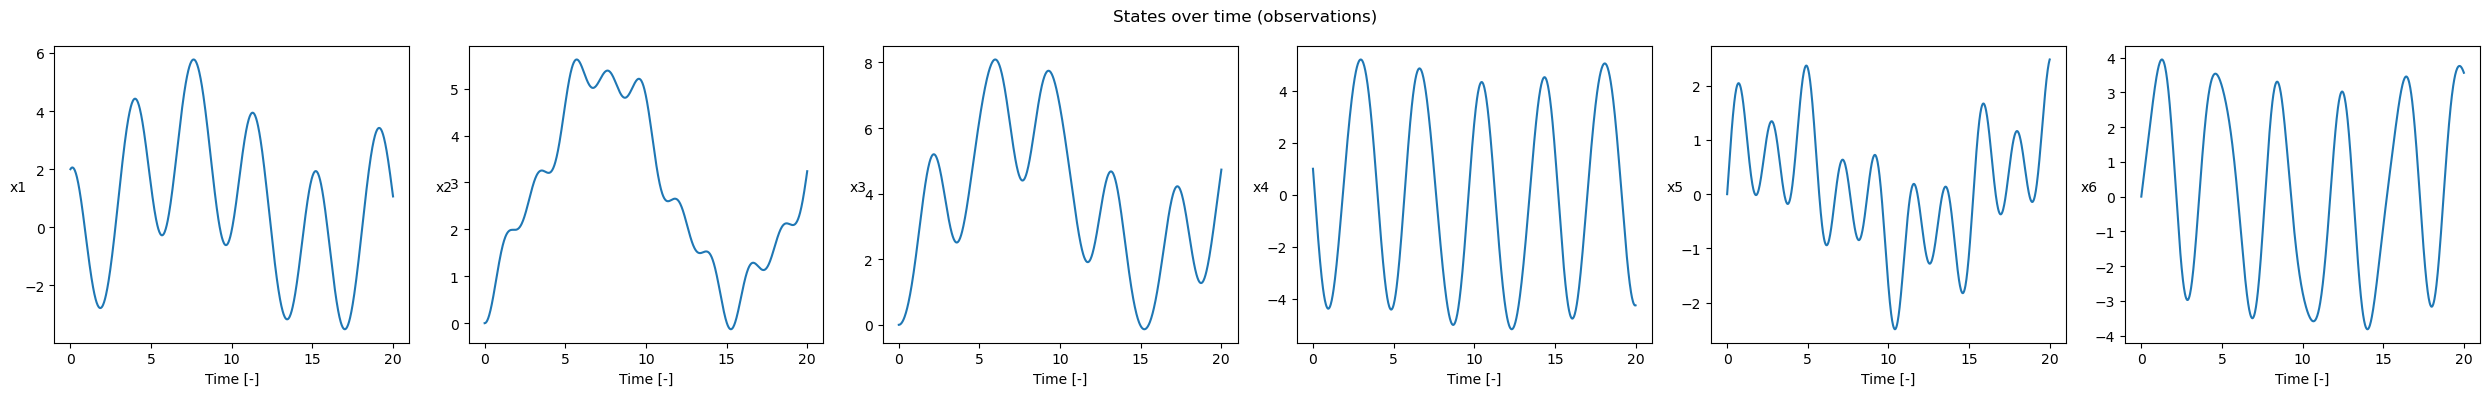

In [15]:
# Visualize
fig = plt.figure(figsize= (25,4))
fig.suptitle("States over time (observations)")

ax = fig.add_subplot(1, 6, 1)
ax.plot(t_grid, gt[:, 0])
ax.set_xlabel("Time [-]")
ax.set_ylabel("x1", rotation=0)

ax = fig.add_subplot(1, 6, 2)
ax.plot(t_grid, gt[:, 1])
ax.set_xlabel("Time [-]")
ax.set_ylabel("x2", rotation=0)

ax = fig.add_subplot(1, 6, 3)
ax.plot(t_grid, gt[:, 2])
ax.set_ylabel("x3", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 4)
ax.plot(t_grid, gt[:, 3])
ax.set_ylabel("x4", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 5)
ax.plot(t_grid, gt[:, 4])
ax.set_ylabel("x5", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 6)
ax.plot(t_grid, gt[:, 5])
ax.set_ylabel("x6", rotation=0)
ax.set_xlabel("Time [-]")

plt.tight_layout()

This creates the batch.

In [16]:
def get_batch(t_data, x_data, batch_size_ic, batch_size_time):
    # We select the initial conditions from which generate predictions
    s = np.random.choice(
        np.arange(gt.shape[0] - batch_size_time, dtype=np.int64),
        batch_size_ic,
        replace=False,
    )
    ic_batch = x_data[s, :]  # (M, n)
    # Assuming uniform grid and a non-autonomous system, all predictions will be made on the same time grid
    t_batch = t_data[:batch_size_time]  # (T)
    t_grids = np.array([t_data[s_:s_+batch_size_time] for s_ in s])  # Used for plotting
    x_batch = np.stack([x_data[s + i] for i in range(batch_size_time)])  # (T, M, n)
    return ic_batch, t_batch, x_batch, t_grids

This instantiates the ffnn as heyoka expression, and defines the neural ODE

In [17]:
# We define as nonlinearity a simple linear layer
linear = lambda inp: inp

# We call the factory to construct a FFNN. Following the torcheqdiff example here we put cubes as inputs:
ffnn = hk.model.ffnn(
    inputs=x_vars,
    nn_hidden=[30, 30],
    n_out=len(x_vars),
    activations=[hk.tanh, hk.tanh, linear]
)

# We thus define the neural dynamics
dyn_n = list(zip(x_vars, ffnn))

We now need the gradient of the loss over the batch

$$
\mathcal L_{\theta} = \sum_{i=0}^{M}\sum_{j=0}^T (\pmb y_{ij} - \hat {\pmb y}_{ij})\cdot (\pmb y_{ij} - \hat {\pmb y}_{ij})
$$

$$
\frac{\partial L_\theta}{\partial \theta} =  2 \sum_{i=0}^{M}\sum_{j=0}^T (\pmb y_{ij} - \hat {\pmb y}_{ij})\cdot \frac{\partial \pmb y_{ij}}{\partial \theta}
$$

hence we need a variational integrator.

In [18]:
var_dyn_n = hk.var_ode_sys(dyn_n, args = hk.var_args.params)
ta_var = hk.taylor_adaptive(
    # The ODEs.
    var_dyn_n,
    # The initial conditions.
    ic,
    # Operate in compact mode.
    compact_mode=True,
    # Define the tolerance
    tol=1e-8,
)
# We store for convenience the initial conditions of the variational state
ic_var = list(ta_var.state[n:])

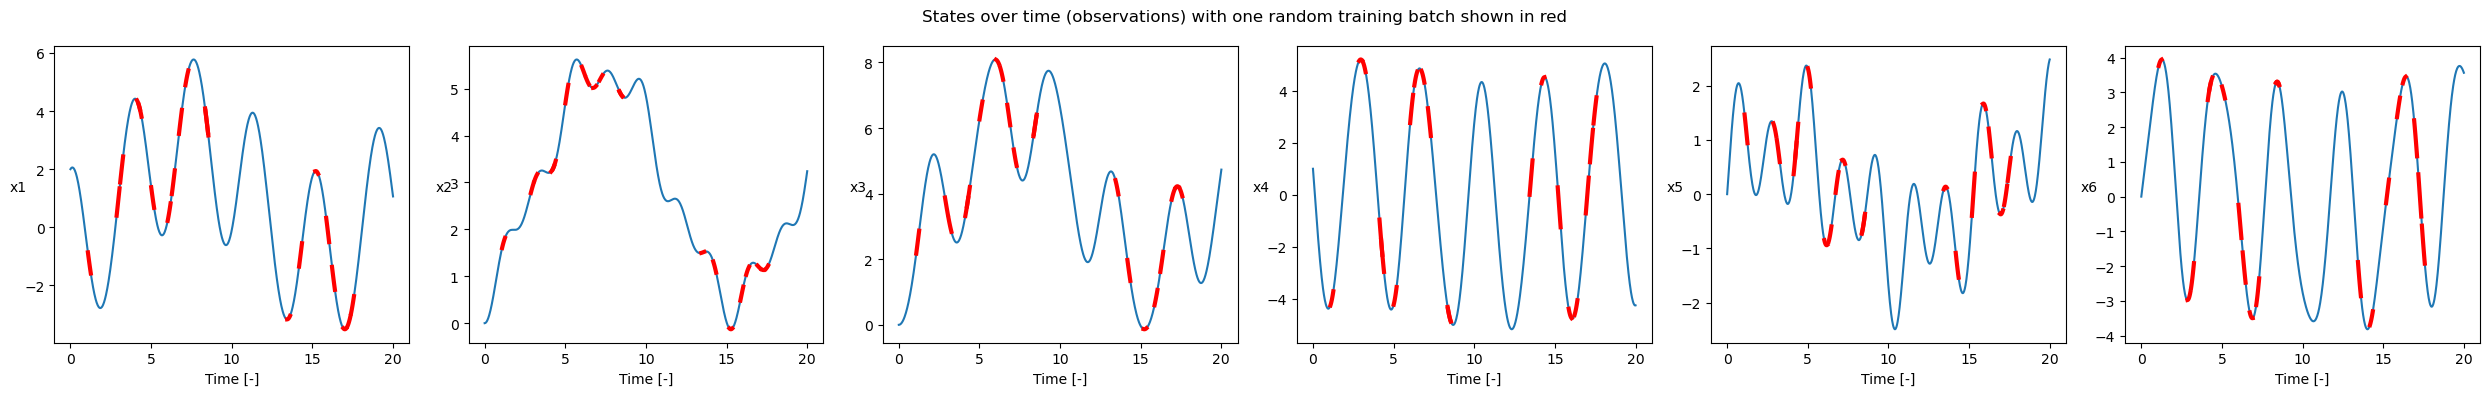

In [19]:
batch_ic, batch_t_grid, batch_y, t_grids = get_batch(t_grid, gt, batch_size_ic, batch_size_time)

# Visualize
fig = plt.figure(figsize= (25,4))
fig.suptitle("States over time (observations) with one random training batch shown in red")

ax = fig.add_subplot(1, 6, 1)
ax.plot(t_grid, gt[:, 0])
for i, t_grid_batch in enumerate(t_grids):
    plt.plot(t_grid_batch, batch_y[:,i,0], linewidth=3, color="red")
ax.set_ylabel("x1", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 2)
ax.plot(t_grid, gt[:, 1])
for i, t_grid_batch in enumerate(t_grids):
    plt.plot(t_grid_batch, batch_y[:,i,1], linewidth=3, color="red")
ax.set_ylabel("x2", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 3)
ax.plot(t_grid, gt[:, 2])
for i, t_grid_batch in enumerate(t_grids):
    plt.plot(t_grid_batch, batch_y[:,i,2], linewidth=3, color="red")
ax.set_ylabel("x3", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 4)
ax.plot(t_grid, gt[:, 3])
for i, t_grid_batch in enumerate(t_grids):
    plt.plot(t_grid_batch, batch_y[:,i,3], linewidth=3, color="red")
ax.set_ylabel("x4", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 5)
ax.plot(t_grid, gt[:, 4])
for i, t_grid_batch in enumerate(t_grids):
    plt.plot(t_grid_batch, batch_y[:,i,4], linewidth=3, color="red")
ax.set_ylabel("x5", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 6)
ax.plot(t_grid, gt[:, 5])
for i, t_grid_batch in enumerate(t_grids):
    plt.plot(t_grid_batch, batch_y[:,i,5], linewidth=3, color="red")
ax.set_ylabel("x6", rotation=0)
ax.set_xlabel("Time [-]")

plt.tight_layout()

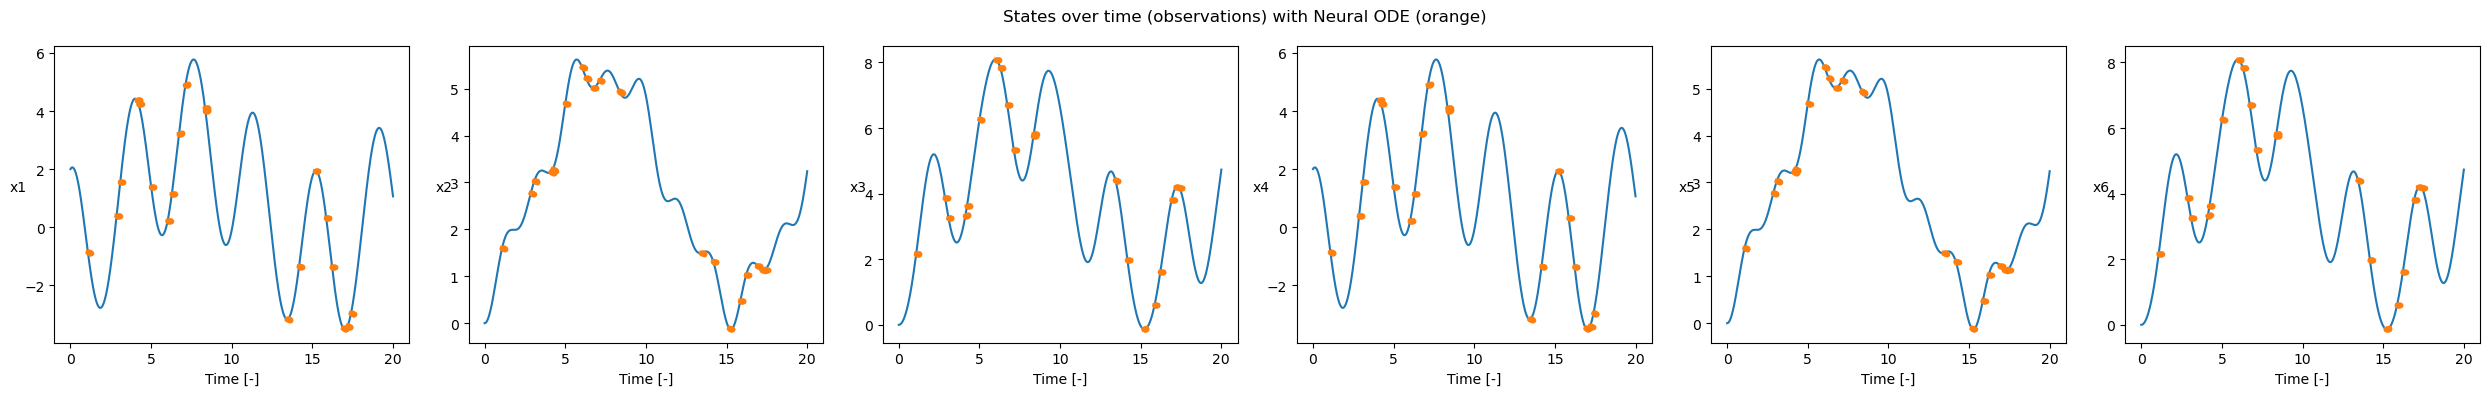

In [20]:
# We find initialization values for weigths / biases
n_pars = len(ta_var.pars)
nn_wb = np.random.normal(loc = 0, scale = 0.1, size = (n_pars, ))

# Visualize
fig = plt.figure(figsize= (25,4))
fig.suptitle("States over time (observations) with Neural ODE (orange)")

ax = fig.add_subplot(1, 6, 1)
ax.plot(t_grid, gt[:, 0])
for one_ic, t_grid_batch in zip(batch_ic,t_grids):
    ta_var.time=0
    ta_var.state[:] = list(one_ic) + ic_var
    ta_var.pars[:] = nn_wb
    sol = ta_var.propagate_grid(batch_t_grid)[5]
    ax.plot(t_grid_batch, sol[:,0], linewidth=3, marker=".", color="#ff7f0e")
ax.set_ylabel("x1", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 2)
ax.plot(t_grid, gt[:, 1])
for one_ic, t_grid_batch in zip(batch_ic,t_grids):
    ta_var.time=0
    ta_var.state[:] = list(one_ic) + ic_var
    ta_var.pars[:] = nn_wb
    sol = ta_var.propagate_grid(batch_t_grid)[5]
    ax.plot(t_grid_batch, sol[:,1], linewidth=3, marker=".", color="#ff7f0e")
ax.set_ylabel("x2", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 3)
ax.plot(t_grid, gt[:, 2])
for one_ic, t_grid_batch in zip(batch_ic,t_grids):
    ta_var.time=0
    ta_var.state[:] = list(one_ic) + ic_var
    ta_var.pars[:] = nn_wb
    sol = ta_var.propagate_grid(batch_t_grid)[5]
    ax.plot(t_grid_batch, sol[:,2], linewidth=3, marker=".", color="#ff7f0e")
ax.set_ylabel("x3", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 4)
ax.plot(t_grid, gt[:, 0])
for one_ic, t_grid_batch in zip(batch_ic,t_grids):
    ta_var.time=0
    ta_var.state[:] = list(one_ic) + ic_var
    ta_var.pars[:] = nn_wb
    sol = ta_var.propagate_grid(batch_t_grid)[5]
    ax.plot(t_grid_batch, sol[:,0], linewidth=3, marker=".", color="#ff7f0e")
ax.set_ylabel("x4", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 5)
ax.plot(t_grid, gt[:, 1])
for one_ic, t_grid_batch in zip(batch_ic,t_grids):
    ta_var.time=0
    ta_var.state[:] = list(one_ic) + ic_var
    ta_var.pars[:] = nn_wb
    sol = ta_var.propagate_grid(batch_t_grid)[5]
    ax.plot(t_grid_batch, sol[:,1], linewidth=3, marker=".", color="#ff7f0e")
ax.set_ylabel("x5", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 6)
ax.plot(t_grid, gt[:, 2])
for one_ic, t_grid_batch in zip(batch_ic,t_grids):
    ta_var.time=0
    ta_var.state[:] = list(one_ic) + ic_var
    ta_var.pars[:] = nn_wb
    sol = ta_var.propagate_grid(batch_t_grid)[5]
    ax.plot(t_grid_batch, sol[:,2], linewidth=3, marker=".", color="#ff7f0e")
ax.set_ylabel("x6", rotation=0)
ax.set_xlabel("Time [-]")

plt.tight_layout()


This returns the value of the loss and gradients of the loss with respect to the network parameters

In [21]:
def loss_and_gradient(nn_wb, batch_ic, batch_y):
    # We loop over the various selected initial conditions and produce the predictions
    # and their gradients
    # We reset the batch_loss value
    batch_loss = 0
    # We reset the gradient loss
    grad = np.array([0.] * len(ta_var.pars))
    for i, ic_ in enumerate(batch_ic):
        ta_var.time=0
        ta_var.state[:] = list(ic_) + ic_var
        ta_var.pars[:] = nn_wb
        sol = ta_var.propagate_grid(batch_t_grid)[5]
        # Here is the term (y-y_hat)
        diff = (sol[:,:n] - batch_y[:,i,:])
        # Which is now summed sum sum (y-y_hat).(y-y_hat)
        batch_loss += np.sum(diff**2)
        # And the gradient computed  as 2 sum (y-y_hat).dy
        for dy in sol[:,n:].reshape(batch_y.shape[0],n,-1):
            grad += 2*np.sum(diff@dy, axis=0)
    # We then take the mean over the points used
    batch_loss /= (batch_size_ic * batch_size_time)
    grad /= (batch_size_ic * batch_size_time)
    return batch_loss, grad

### Simple fixed learning rate stochastic gradient descent

In [22]:
# We create a random batch
batch_losses = []
learning_rate = 1e-2

for i in range(300):
    batch_ic, batch_t_grid, batch_y, _ = get_batch(t_grid, gt, batch_size_ic=20, batch_size_time=10)
    batch_loss, grad = loss_and_gradient(nn_wb, batch_ic, batch_y)
    print(f"iter: {i}, loss : {batch_loss:.3e}", end="\r")
    nn_wb = nn_wb - learning_rate * grad
    batch_losses.append(batch_loss)

Text(0.5, 1.0, 'Training batch loss over gradient descent steps')

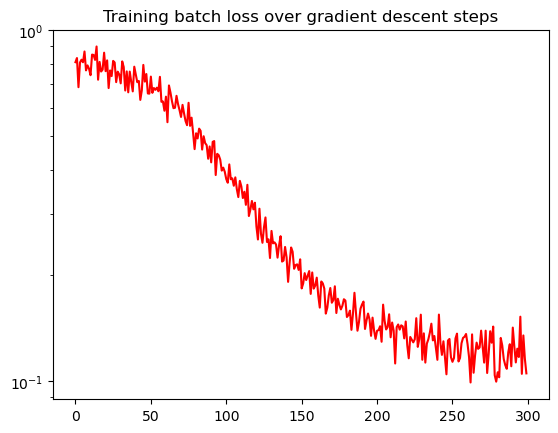

In [23]:
plt.semilogy(batch_losses, color="red")
plt.title("Training batch loss over gradient descent steps")

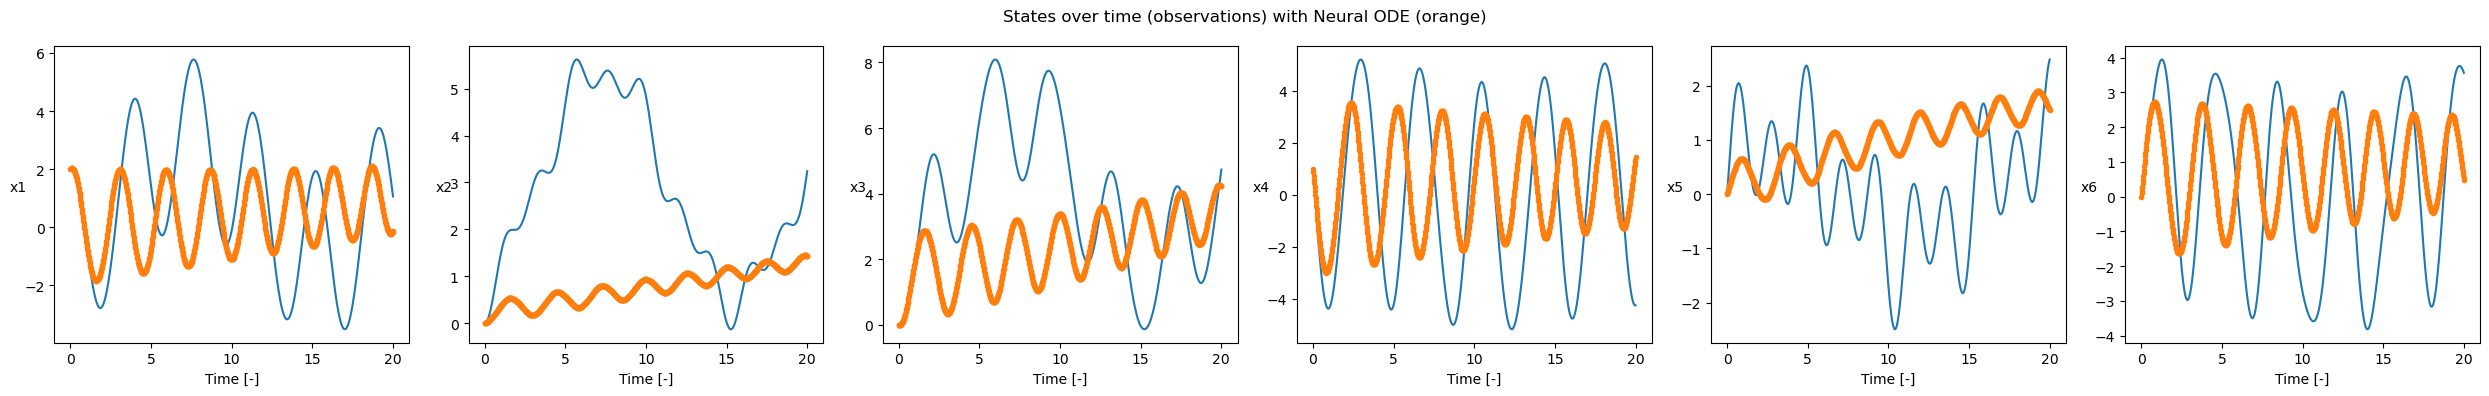

In [24]:
ta_var.time = 0
ta_var.state[:] = ic + ic_var
ta_var.pars[:] = nn_wb
sol = ta_var.propagate_grid(t_grid)[5]

# Visualize
fig = plt.figure(figsize= (25,4))
fig.suptitle("States over time (observations) with Neural ODE (orange)")

ax = fig.add_subplot(1, 6, 1)
ax.plot(t_grid, gt[:, 0])
ax.plot(t_grid, sol[:,0], marker=".")
ax.set_ylabel("x1", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 2)
ax.plot(t_grid, gt[:, 1])
ax.plot(t_grid, sol[:,1], marker=".")
ax.set_ylabel("x2", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 3)
ax.plot(t_grid, gt[:, 2])
ax.plot(t_grid, sol[:,2], marker=".")
ax.set_ylabel("x3", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 4)
ax.plot(t_grid, gt[:, 3])
ax.plot(t_grid, sol[:,3], marker=".")
ax.set_ylabel("x4", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 5)
ax.plot(t_grid, gt[:, 4])
ax.plot(t_grid, sol[:,4], marker=".")
ax.set_ylabel("x5", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 6)
ax.plot(t_grid, gt[:, 5])
ax.plot(t_grid, sol[:,5], marker=".")
ax.set_ylabel("x6", rotation=0)
ax.set_xlabel("Time [-]")

plt.tight_layout()


### Now we do the same training with the Adam Optimizer

In [25]:
# Reinitialize values for weigths / biases
n_pars = len(ta_var.pars)
nn_wb = np.random.normal(loc = 0, scale = 0.1, size = (n_pars, ))

In [26]:
# Set desired precision
precision = np.single # np.double
learning_rate = 1e-2

# Determine the PyTorch dtype based on precision
dtype = torch.float32 if precision == np.single else torch.float64

# Gradient descent using the Adam optimizer 
weights_biases_tensor = torch.tensor(nn_wb, dtype= dtype, requires_grad=True)
optimizer = torch.optim.Adam([weights_biases_tensor], lr=precision(learning_rate), betas=(0.9, 0.999), eps=precision(1e-8), amsgrad=True)

In [27]:
# We create a random batch
batch_losses = []

for i in range(300):
    batch_ic, batch_t_grid, batch_y, _ = get_batch(t_grid, gt, batch_size_ic=20, batch_size_time=10)
    batch_loss, grad = loss_and_gradient(nn_wb, batch_ic, batch_y)
    print(f"iter: {i}, loss : {batch_loss:.3e}", end="\r")
    batch_losses.append(batch_loss)

    # Clear the gradients for the next iteration
    optimizer.zero_grad()

    # weights_biases_tensor.data = torch.tensor(current_weights)
    weights_biases_tensor.data = torch.tensor(np.array(nn_wb), dtype=dtype, requires_grad=True)
    
    # Convert to tensor
    dLdw_tensor = torch.tensor(np.squeeze(grad), dtype=dtype)

    # Manually set the gradients for the parameter
    weights_biases_tensor.grad = dLdw_tensor

    # Use the Adam optimizer to perform the weight update
    optimizer.step()

    # Convert back to array
    nn_wb = weights_biases_tensor.detach().numpy()

Text(0.5, 1.0, 'Training batch loss over gradient descent steps')

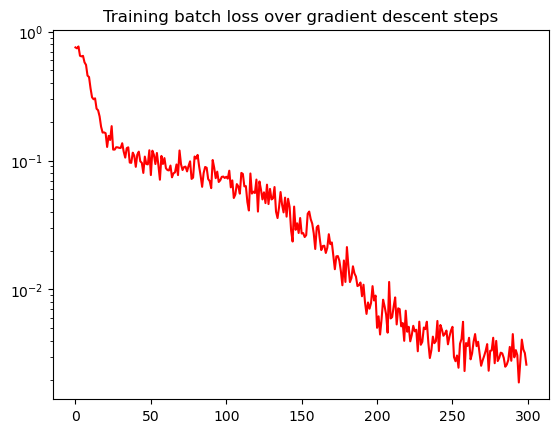

In [28]:
plt.semilogy(batch_losses, color="red")
plt.title("Training batch loss over gradient descent steps")

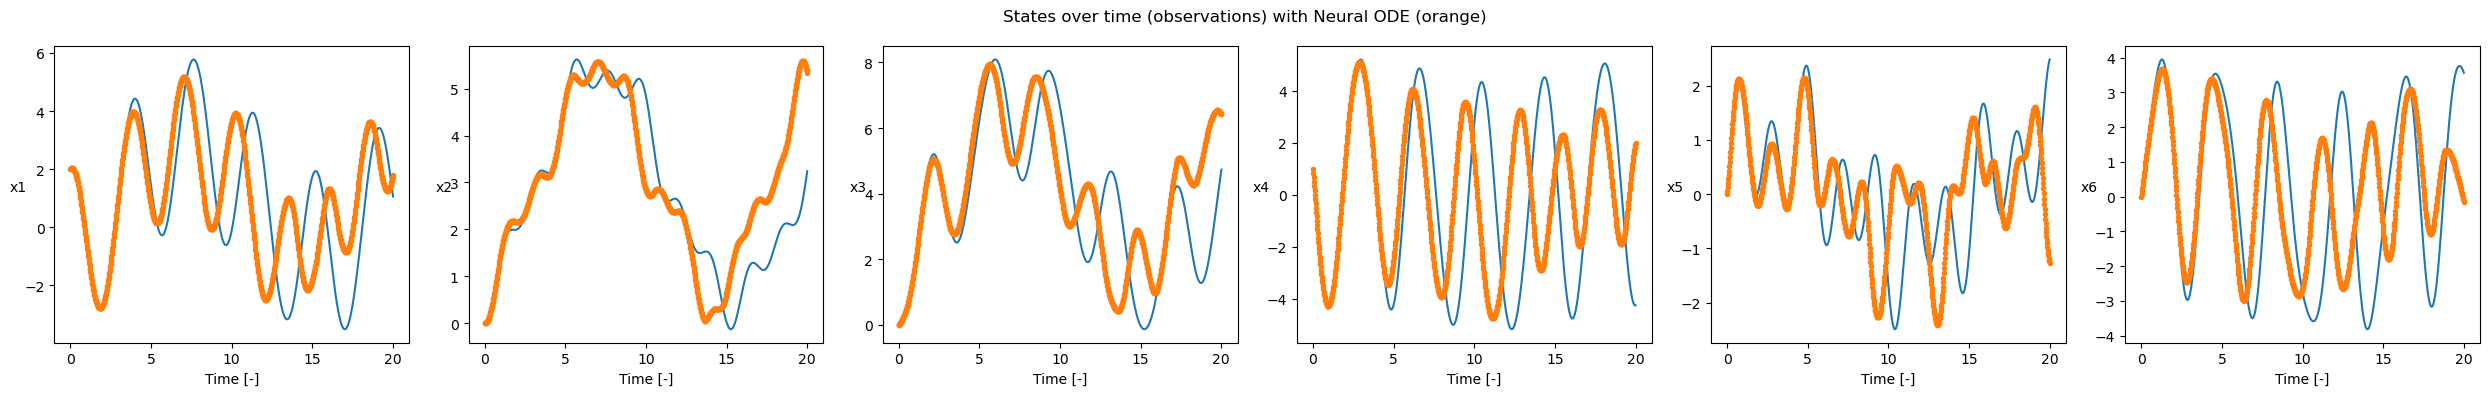

In [29]:
ta_var.time = 0
ta_var.state[:] = ic + ic_var
ta_var.pars[:] = nn_wb
sol = ta_var.propagate_grid(t_grid)[5]

# Visualize
fig = plt.figure(figsize= (25,4))
fig.suptitle("States over time (observations) with Neural ODE (orange)")

ax = fig.add_subplot(1, 6, 1)
ax.plot(t_grid, gt[:, 0])
ax.plot(t_grid, sol[:,0], marker=".")
ax.set_ylabel("x1", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 2)
ax.plot(t_grid, gt[:, 1])
ax.plot(t_grid, sol[:,1], marker=".")
ax.set_ylabel("x2", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 3)
ax.plot(t_grid, gt[:, 2])
ax.plot(t_grid, sol[:,2], marker=".")
ax.set_ylabel("x3", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 4)
ax.plot(t_grid, gt[:, 3])
ax.plot(t_grid, sol[:,3], marker=".")
ax.set_ylabel("x4", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 5)
ax.plot(t_grid, gt[:, 4])
ax.plot(t_grid, sol[:,4], marker=".")
ax.set_ylabel("x5", rotation=0)
ax.set_xlabel("Time [-]")

ax = fig.add_subplot(1, 6, 6)
ax.plot(t_grid, gt[:, 5])
ax.plot(t_grid, sol[:,5], marker=".")
ax.set_ylabel("x6", rotation=0)
ax.set_xlabel("Time [-]")

plt.tight_layout()